# Testing as library

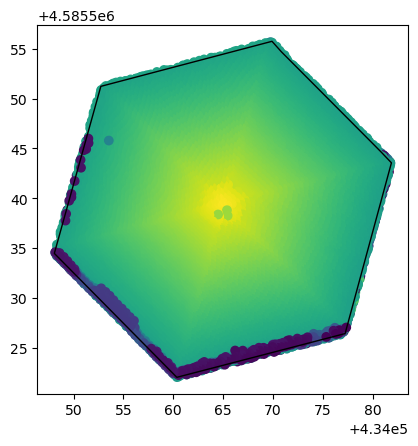

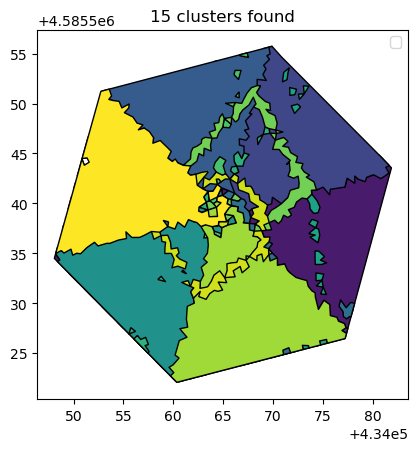

In [12]:
import matplotlib.pyplot as plt
import geopandas as gpd
import laspy

basePath = "/home/jaumeasensio/Documents/Projectes/BEEGroup/solar_potencial_estimation_v3/"
neighborhood = "Test_70_el Besòs i el Maresme"
parcelsFolder = basePath + "/Results/" + neighborhood + "/Parcels/"

parcel = "4151302DF3845A" # "4157903DF3845E" # 
construction = 139 # 86 # 
parcel = "4157903DF3845E" # 
construction = 86 # 
# parcel = "4054901DF3845C" # 
# construction = 490 # 
construction = str(construction)

lasPath = parcelsFolder + parcel + "/" + construction + "/Map files/" + construction + ".laz"
lasDF = laspy.read(lasPath)

gpkgFile = parcelsFolder + parcel + "/" + construction + "/Map files/" + construction + ".gpkg"
        
plt.scatter(lasDF.x, lasDF.y, c=lasDF.z)
cadasterGDF = gpd.read_file(gpkgFile)
cadasterGDF.plot(ax = plt.gca(), color='none', edgecolor='black')
plt.gca().set_aspect('equal')
plt.show()

from planeIdentification import *
from getVoronoiClipped import getVoronoiClipped

pipeline = ClusterPipeline([
    heightSplit(distance_threshold = 0.45),  # First clustering stage
    PlanesCluster(inlierThreshold=0.15, num_iterations=10, maxPlanes=20, iterationsToConverge=10)
    # DBSCAN(eps=1.5, min_samples=8),
])

# Fit the pipeline
pipeline.fit(lasDF.xyz)
vorClipped = getVoronoiClipped(lasDF.xyz, pipeline.final_labels, cadasterGDF)

# plot_clusters(lasDF.xyz, pipeline.final_labels, title="Final Stage Clustering")

vorClipped = vorClipped[vorClipped.cluster != -1]
vorClipped['cluster'] = [i for i in range(len(vorClipped))]

vorClipped.plot(ax = plt.gca(), column = 'cluster', edgecolor='black')
plt.legend(vorClipped['cluster'])
plt.title(f"{len(vorClipped):.0f} clusters found")
plt.show()

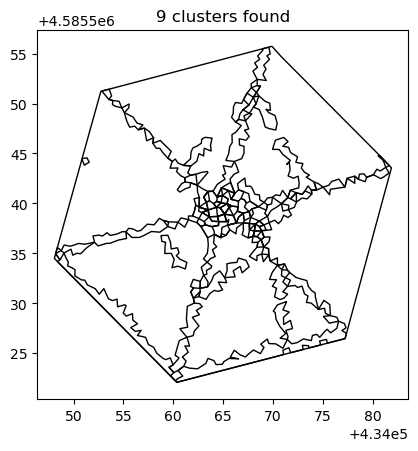

In [13]:
def filter_polygons_by_area(geometry, threshold):
    if isinstance(geometry, Polygon):
        return geometry if geometry.area >= threshold else None
    elif isinstance(geometry, MultiPolygon):
        filtered_polygons = [poly for poly in list(geometry.geoms) if poly.area >= threshold]
        if len(filtered_polygons) == 1:
            return filtered_polygons[0]
        elif len(filtered_polygons) > 1:
            return MultiPolygon(filtered_polygons)
        else:
            return None
    return geometry  # For non-polygon geometries, return as-is

vorDeleted = vorClipped
vorDeleted["geometry"] = vorDeleted["geometry"].apply(lambda geom: filter_polygons_by_area(geom, 2))
vorDeleted = vorDeleted[vorDeleted.geometry != None] 

vorDeleted.plot(ax = plt.gca(), color='None', edgecolor='black')
plt.title(f"{len(vorDeleted):.0f} clusters found")
plt.show()

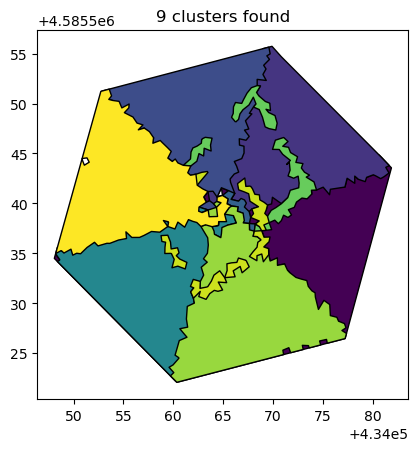

In [14]:
vorDeleted.plot(ax = plt.gca(), column='cluster', edgecolor='black')
plt.title(f"{len(vorDeleted):.0f} clusters found")
plt.show()

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import laspy
from shapely.geometry import MultiPolygon, Polygon

# Read data

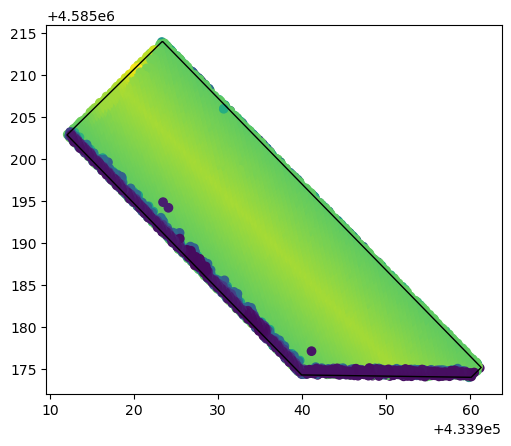

In [84]:
basePath = "/home/jaumeasensio/Documents/Projectes/BEEGroup/solar_potencial_estimation_v3/"
neighborhood = "Test_70_el Besòs i el Maresme"
parcelsFolder = basePath + "/Results/" + neighborhood + "/Parcels/"

parcel = "4151302DF3845A" # "4157903DF3845E" # 
construction = 139 # 86 # 
parcel = "4157903DF3845E" # 
construction = 86 # 
parcel = "4054901DF3845C" # 
construction = 490 # 
construction = str(construction)

lasPath = parcelsFolder + parcel + "/" + construction + "/Map files/" + construction + ".laz"
lasDF = laspy.read(lasPath)

gpkgFile = parcelsFolder + parcel + "/" + construction + "/Map files/" + construction + ".gpkg"
        
plt.scatter(lasDF.x, lasDF.y, c=lasDF.z)
cadasterGDF = gpd.read_file(gpkgFile)
cadasterGDF.plot(ax = plt.gca(), color='none', edgecolor='black')
plt.gca().set_aspect('equal')
plt.show()

# Apply clustering

## Algorithm definition

In [3]:
class ClusterPipeline:
    def __init__(self, clustering_stages):
        self.clustering_stages = clustering_stages # Each stage is a clustering class

    def fit(self, X, y=None):
        self.stage_labels = []
        self.final_labels = np.zeros(X.shape[0], dtype=str)
        
        current_data = X 
        current_labels = np.zeros(X.shape[0], dtype=int)  # Initialize labels

        for stage in self.clustering_stages:
            
            new_labels = np.zeros_like(current_labels)  # New labels for this stage
            unique_clusters = np.unique(current_labels)  # Unique clusters in current stage
            cluster_offset = 0 

            for cluster_id in unique_clusters:
                
                cluster_data = current_data[current_labels == cluster_id]
                if len(cluster_data) < 3:  # Skip small clusters
                    continue
                
                # Fit the clustering algorithm to the current cluster
                stage.fit(cluster_data)
                cluster_stage_labels = stage.labels_

                # Assign new labels offset by cluster_offset
                new_labels[current_labels == cluster_id] = (cluster_stage_labels + cluster_offset)
                cluster_offset += len(np.unique(cluster_stage_labels)) # Update cluster offset for the next unique label
                

            # Store the stage labels and update current labels
            self.stage_labels.append(new_labels.copy())
            current_labels = new_labels
            
        self.final_labels = self.stage_labels[-1]
        return self


In [4]:
class heightSplit():
    def __init__(self, distance_threshold=0.45):
        self.distance_threshold = distance_threshold
        
    def fit(self, X):
        n_samples, n_features = X.shape

        X = X[X[:, 2].argsort()]
        
        deltaZ = np.diff(X[:,2], prepend=0)
        
        labels = np.zeros_like(deltaZ, dtype=int)

        current_label = 0
        for i in range(1, len(deltaZ)):
            if deltaZ[i] > self.distance_threshold:
                current_label += 1
            labels[i] = current_label

        self.labels_ = labels
        return self

    def predict(self, X):
        pass

    def fit_predict(self, X, y=None):
        self.fit(X)
        return self.labels_

In [79]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

class PlanesCluster():
    def __init__(self, inlierThreshold=0.15, num_iterations=10, maxPlanes=20, iterationsToConverge=10):
        self.inlierThreshold = inlierThreshold
        self.num_iterations = num_iterations
        self.maxPlanes = maxPlanes
        self.iterationsToConverge = iterationsToConverge

    def sampleFar(self, X, n_planes):
        centroids = np.zeros((n_planes, X.shape[1]))
        index = np.random.choice(X.shape[0], 1)
        centroids[0, :] = X[index,:]
        distances = np.zeros((X.shape[0], n_planes-1))
        for i in range(1, n_planes):
            distances[:, i-1] = (np.linalg.norm(X[:,:] - centroids[i-1,:], axis=1))
            average_distances = distances.mean(axis=1)
            normalized_distances = average_distances / average_distances.sum()
            selected_index = np.random.choice(len(X), p=normalized_distances)
            centroids[i, :] = X[selected_index,:]
        return centroids
        
    def sample2Close(self, X, centroids):
        triplets = np.zeros((centroids.shape[0], X.shape[1], 3)) # n_planes * 3 coordinates * 3 points/plane
        for i in range(len(centroids)):
            triplets[i, 0, :] = centroids[i]
            # sample two points
            distances = np.linalg.norm(X[:,:] - centroids[i,:], axis=1)
            closeness = distances.max() - distances
            probabilities = closeness / closeness.sum()
            # probabilities = probabilities**2
            # probabilities /= probabilities.sum()
            selected_indexes = np.random.choice(len(X), 2, p=probabilities)
            # selected_indexes = np.random.choice(len(X), 2)
            triplets[i, 1:3, :] = X[selected_indexes,:]
        return triplets

    def fit(self, X):
        best_score = -np.inf
        best_labels = []    

        for n_planes in range(1, self.maxPlanes+1):
            best_score_n = -np.inf
            best_labels_n = []    

            for i in range(self.num_iterations):
                # Sample points and get planes
                centroids = self.sampleFar(X, n_planes)
                triplets = self.sample2Close(X, centroids)

                planes = []
                for triplet in triplets:
                    reg = LinearRegression().fit(triplet[:,0:2], triplet[:,2])
                    planes.append(reg)
                
                # Compute distances and find inliers
                distances = np.zeros((X.shape[0], n_planes))
                for plane_idx in range(len(planes)):
                    distances[:, plane_idx] = abs(X[:,2] - planes[plane_idx].predict(X[:,0:2]))
                labels = np.argmin(distances, axis=1)

                selected_distances = np.array([distances[i, idx] for i, idx in enumerate(labels)])
                labels[np.where(selected_distances > self.inlierThreshold)[0]] = -1
                
                lastLabels = labels
                oldPlanes = planes
                for j in range(self.iterationsToConverge):
                    planes = []
                    for k in range(n_planes):
                        try:
                            reg = LinearRegression().fit(X[np.where(labels == k)[0],0:2], X[np.where(labels == k)[0],2])
                            planes.append(reg)
                        except:
                            pass
                    distances = np.zeros((X.shape[0], n_planes))

                    for plane_idx in range(len(planes)):
                        distances[:, plane_idx] = abs(X[:,2] - planes[plane_idx].predict(X[:,0:2]))
                    labels = np.argmin(distances, axis=1)

                    selected_distances = np.array([distances[i, idx] for i, idx in enumerate(labels)])
                    labels[np.where(selected_distances > self.inlierThreshold)[0]] = -1
                    
                    if(np.array_equal(lastLabels, labels)):
                        break
                    else:
                        lastLabels = labels
                        oldPlanes = planes

                if(not np.array_equal(lastLabels, labels)): print("Did not converge")
                
                inliers = X[np.where(labels != -1)[0]]
                labelsScore = labels[np.where(labels != -1)[0]]
                prediction = np.zeros((inliers.shape[0]))
                for plane_idx in range(len(planes)):
                    try:
                        prediction[np.where(labelsScore == plane_idx)[0]] = planes[plane_idx].predict(inliers[np.where(labelsScore == plane_idx)[0],0:2])
                    except:
                        pass
                rmse = root_mean_squared_error(inliers[:,2], prediction)
                if(len(planes) == 0):
                    score = 0
                else:
                    score = len(inliers)/len(X)*1/rmse
                
                if(score > best_score_n):
                    best_score_n = score
                    best_labels_n = labels    

            if(best_score_n > best_score):
                best_score = best_score_n
                best_labels = best_labels_n

        self.labels_ = best_labels
        return self

    def predict(self, X):
        pass

    def fit_predict(self, X, y=None):
        self.fit(X)
        return self.labels_

In [253]:
planesCluster = PlanesCluster(num_iterations=5, maxPlanes=20, iterationsToConverge=10)
results = planesCluster.fit(lasDF.xyz)
results.labels_

array([-1,  0,  0, ..., -1, -1,  0])

In [248]:
planesCluster.labels_

array([-1,  0,  0, ..., -1,  0, -1])

In [8]:
# from sklearn.cluster import KMeans

# def plot_clusters(X, labels, title="Cluster Plot"): # Plot results of the last stage of clustering
#     plt.figure(figsize=(8, 6))
#     unique_labels = np.unique(labels)
#     for label in unique_labels:
#         cluster_points = X[labels == label]
#         plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=5, label=f"{label}")
#     plt.title(title)
#     plt.xlabel("x (m)")
#     plt.ylabel("y (m)")
#     plt.legend()
#     plt.gca().set_aspect('equal')
#     plt.show()

## Test on real data

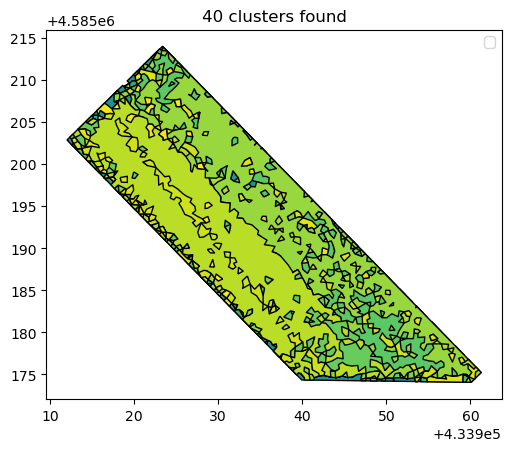

In [93]:
from getVoronoiClipped import getVoronoiClipped

pipeline = ClusterPipeline([
    heightSplit(distance_threshold = 0.45),  # First clustering stage
    PlanesCluster(inlierThreshold=0.05, num_iterations=10, maxPlanes=20, iterationsToConverge=10)
    # DBSCAN(eps=1.5, min_samples=8),
])

# Fit the pipeline
pipeline.fit(lasDF.xyz)
vorClipped = getVoronoiClipped(lasDF.xyz, pipeline.final_labels, cadasterGDF)

# plot_clusters(lasDF.xyz, pipeline.final_labels, title="Final Stage Clustering")

vorClipped = vorClipped[vorClipped.cluster != -1]
vorClipped['cluster'] = [i for i in range(len(vorClipped))]

vorClipped.plot(ax = plt.gca(), column = 'cluster', edgecolor='black')
plt.legend(vorClipped['cluster'])
plt.title(f"{len(vorClipped):.0f} clusters found")
plt.show()

In [57]:
np.unique(pipeline.final_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37])

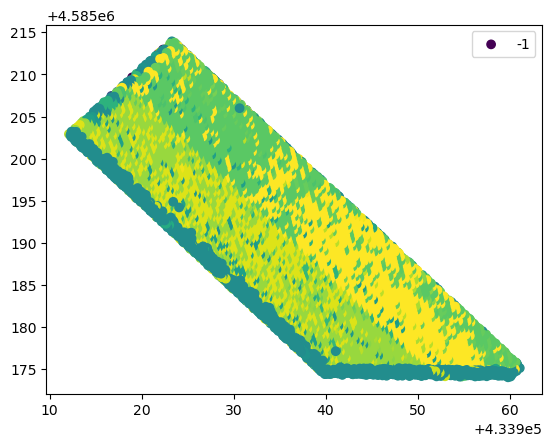

In [86]:
plt.scatter(lasDF.x, lasDF.y, c=pipeline.final_labels)
plt.legend(np.unique(pipeline.final_labels))

In [94]:
def filter_polygons_by_area(geometry, threshold):
    if isinstance(geometry, Polygon):
        return geometry if geometry.area >= threshold else None
    elif isinstance(geometry, MultiPolygon):
        filtered_polygons = [poly for poly in list(geometry.geoms) if poly.area >= threshold]
        if len(filtered_polygons) == 1:
            return filtered_polygons[0]
        elif len(filtered_polygons) > 1:
            return MultiPolygon(filtered_polygons)
        else:
            return None
    return geometry  # For non-polygon geometries, return as-is

vorClipped["geometry"] = vorClipped["geometry"].apply(lambda geom: filter_polygons_by_area(geom, 5))
vorClipped = vorClipped[vorClipped.geometry != None] 
vorClipped.geometry.area

vorClipped.plot(ax = plt.gca(), column = 'cluster', edgecolor='black')
plt.title(f"{len(vorClipped):.0f} clusters found")
plt.show()

1      25.810599
4       5.279180
12      7.435949
15      6.540672
21     91.962142
22    181.635787
25      5.922103
30    355.461078
31    314.521061
33     13.486671
34    276.243659
36    292.422465
37      8.282904
dtype: float64

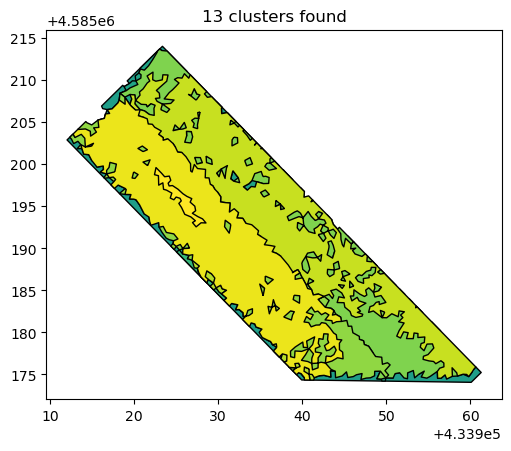

In [95]:
vorClipped.plot(ax = plt.gca(), column = 'cluster', edgecolor='black')
plt.title(f"{len(vorClipped):.0f} clusters found")
plt.show()